# Comparison Example

In this notebook, we show some examples of comparisons between simulations of theoretical models and experimental data, being this the main goal of our software in the long term. This aspect of the NeuralPlayground (NPG) software is still under development. With time, we want to implement tools exclusively made to compare simulated and experimental data, such as a GUI to quickly navigate through the results, add useful metrics to measure the performance of agents or similarity between neural representation, and a "simulation manager" to keep track of the state of all of your runs and available results. For now, this notebook uses the three main modules of NPG, "experiments", "arenas" and "agents", to simulate theoretical models and compare with what is seen in neural recording from real experiments.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import sys
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from neuralplayground.arenas import Wernle2018, MergingRoom, Sargolini2006, Simple2D, BasicSargolini2006,Hafting2008
from neuralplayground.agents import Weber2018, Stachenfeld2018, RandomAgent, LevyFlightAgent
from neuralplayground.experiments import Wernle2018Data, Hafting2008Data, Sargolini2006Data
from neuralplayground.comparison import GridScorer


/Users/clementine/miniconda3/envs/NPG/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float64
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
100%|████████████████████████████████████████████████████████████████████████████████████| 4900/4900 [00:08<00:00, 588.00it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

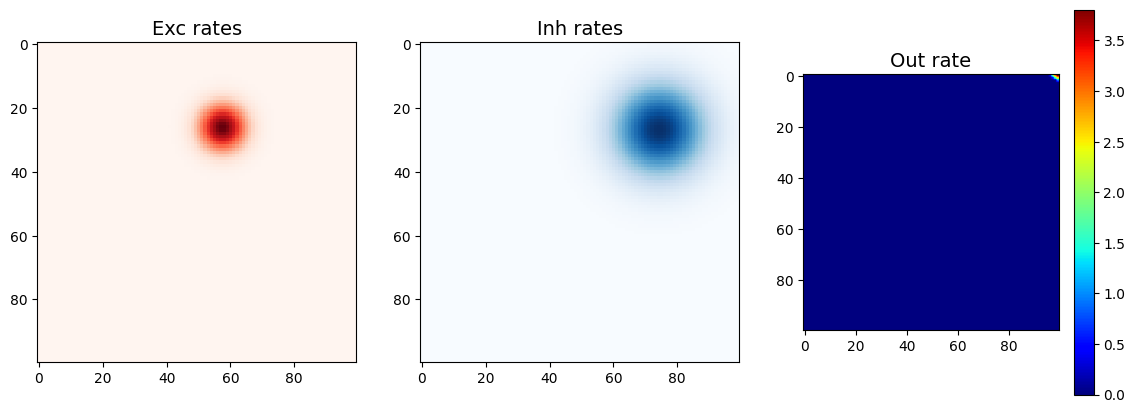

In [3]:
# Parameters for a square environment
room_width = [-10,10]
room_depth = [-10,10]
env_name = "env_example"
time_step_size = 1
agent_step_size = 0.5

# Init environment
envsimple = Simple2D(arena_x_limits = room_width,
                     arena_y_limits = room_depth,
                     time_step_size = time_step_size,
                     agent_step_size = agent_step_size)

exc_eta = 2e-4
inh_eta = 8e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 4900
Ni = 1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.5
agent_step_size = 0.1
roh = 1
agent_Webber = Weber2018(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                  sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=roh,
                  Nef=Nef, Nif=Nif, room_width=envsimple.room_width, room_depth=envsimple.room_depth,
                  alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init)

plot_every = 100000  
total_iters = 0
n_steps = 40
obs, state = envsimple.reset()
for i in tqdm(range(n_steps)):
    # Observe to choose an action, the first to numbers in the observation are the xy position of the agent
    obs = obs[:2]
    action = agent_Webber.act(obs)
    # rate = agent.update()
    agent_Webber.update()
    # Run environment for given action
    obs, state, reward = envsimple.step(action, normalize_step=True)
    total_iters += 1
    if i % plot_every == 0:
        agent_Webber.plot_rates()




10000


/Users/clementine/Documents/UCL/lectures/NeuralPlayground/neuralplayground/comparison/metrics.py:132: RuntimeWarning: invalid value encountered in divide
  mapCovar / mapStd / mapStd[::-1, :, :][:, ::-1, :][:, :, :])


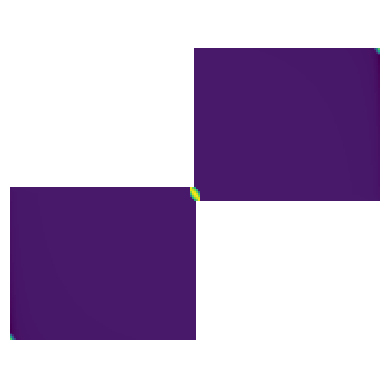

In [4]:
r_out= agent_Webber.get_full_output_rate()
print(r_out.size)
r_out_im = r_out.reshape((agent_Webber.resolution_width, agent_Webber.resolution_depth))
GridScorer_Webber = GridScorer(agent_Webber.resolution_width)
score_Webber = GridScorer_Webber.get_scores(r_out_im)
GridScorer_Webber.plot_sac(score_Webber[0])

<Axes: >

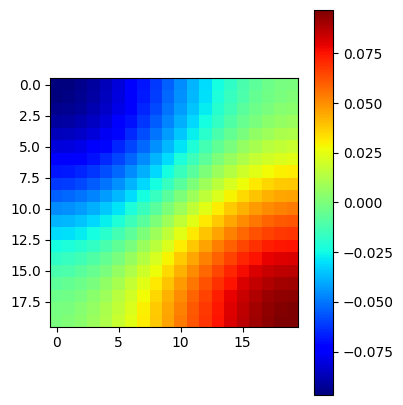

In [5]:
agent_step_size = 1
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True

agent_SR = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=envsimple.room_width, room_depth=envsimple.room_depth, state_density=state_density, twoD=twoDvalue)
sr = agent_SR.update_successor_rep() # One can compute the successor representation using successive additive update
agent_SR.plot_eigen(sr,eigen=[2], save_path=None)




Try on real data

/Users/clementine/miniconda3/envs/NPG/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float64
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


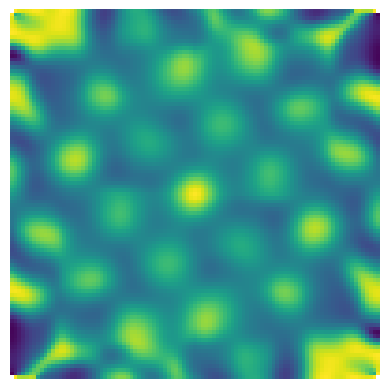

In [6]:
sargolini_data = Sargolini2006Data(verbose=False)
data_path = data_path = "../../neuralplayground/experiments/sargolini_2006/"
env = BasicSargolini2006(data_path=data_path,
                         time_step_size=1,
                         agent_step_size=None)
    
rate_map, x_bin, y_bin = sargolini_data.recording_tetr(recording_index=2)#, tetrode_id="T6C1")
r_out_im = rate_map.reshape((x_bin.size-1, y_bin.size-1))
GridScorer_Sargolini = GridScorer(x_bin.size-1)
score_Sargolini = GridScorer_Sargolini.get_scores(r_out_im)
score_Sargolini = GridScorer_Sargolini.get_scores(r_out_im)
GridScorer_Sargolini.plot_sac(score_Sargolini[0])


/Users/clementine/miniconda3/envs/NPG/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float64
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


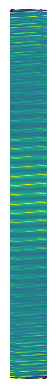

In [7]:
hafting_data = Hafting2008Data(verbose=False)
data_path = data_path = "../../neuralplayground/experiments/hafting_2008/"
env = Hafting2008(data_path=data_path,
                         time_step_size=1,
                         agent_step_size=None)
    
rate_map, x_bin, y_bin = hafting_data.recording_tetr(recording_index=2)#, tetrode_id="T6C1")
r_out_im = rate_map.reshape((x_bin.size-1, y_bin.size-1))
GridScorer_Hafting = GridScorer(x_bin.size-1)
score_Hafting = GridScorer_Hafting.get_scores(r_out_im)
GridScorer_Hafting.plot_sac(score_Hafting[0])

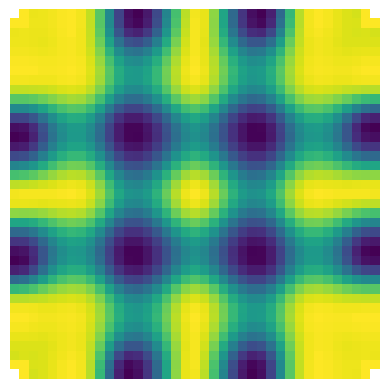

In [8]:
evals, evecs = np.linalg.eig(sr)
evecs_0 = evecs[:, 10].reshape(agent_SR.depth, agent_SR.width).real
r_out_im = evecs_0.reshape((agent_SR.resolution_width, agent_SR.resolution_depth))
GridScorer_SR = GridScorer(agent_SR.resolution_width)
score_SR = GridScorer_SR.get_scores(r_out_im)
GridScorer_SR.plot_sac(score_SR[0])


In [9]:
print('GridScorer_SR')
print(score_SR[1])
print('GridScorer_Webber')
print(score_Webber[1])
print('GridScorer_Sargo')
print(score_Sargolini[1])

GridScorer_SR
{'gridscore': nan, 'scale': 13.0, 'orientation': -0.0, 'closest_peak_coords': array([[ 6, 19],
       [19,  6],
       [19, 32],
       [32, 19],
       [ 1, 19],
       [19,  1]]), 'dist_to_centre': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'ellipse_axes': [17.33175457417619, 16.495623124001224], 'ellipse_angle': 2.2304048245984074, 'ellipseXY': array([[-11.55456656,  12.94105027],
       [-13.13429451,  11.53594096],
       [-14.51368636,   9.92901374],
       [-15.67009254,   8.14665432],
       [-16.58452488,   6.21812899],
       [-17.24196843,   4.17510408],
       [-17.63162799,   2.05112601],
       [-17.74710536,  -0.11892957],
       [-17.58650439,  -2.2994303

In [10]:
NOTE TO SELF:
Does not work with hafting
+ also make sure I fully understans the measure 
Make sure to clarify each score  
Comment the code 
Check on all of the experimental data and on Tem as well ? because does it with the pathches and we need rout

SyntaxError: invalid syntax (458219522.py, line 1)